# Add Folders to Path

We start by adding the necessary folders to the current working path.

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add TSE folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/TSE")

# add ActiveBarriers folder to current working path
sys.path.append(parent_directory+"/demos/ActiveBarriers")

# Overview

We illustrate the numerical implementation and the use of the active Trajectory Rotation Average (aTRA) on 2-D homogeneous, isotropic turbulence. The active single-trajectory LCS diagnostic is applied to the two-dimensional and steady instantaneous vorticity barrier equation. The notebook is structured as follows:

1. Import vorticity and velocity data stored in the folder 'data/Turbulence'. Make sure that all the necessary files are stored in the folder 'data/Turbulence'.
<br />
2. Define computational parameters (such as the number of cores) and variables.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. Apply active (averaged) Trajectory Rotation Angle (a$\mathrm{\overline{TSE}}$) to instantaneous vorticity barrier equation:

   <br />
    
    For 2D incompressible, uniform-density Navier–Stokes flows, the Eulerian barrier equation for vorticity is an autonomous Hamiltonian system of the form:
    
    \begin{equation}
    \mathbf{x}'(s)=\nu \rho \mathbf{J} \nabla \dfrac{D}{Dt}\mathbf{\omega (\mathbf{x}}, t),
    \label{eq: vorticity} 
    \end{equation}
    
    Time 't' is just a fixed parameter and hence the system is autonomous and the integration is done with respect to a dummy time variable 's'. 's' can be arbitrarily large and the aPRA is only limited by the spatial resolution and domain. It can thus potentially reveal finer and more resolved structures compared to the classic version of the PRA, which is fundamentally limited by the temporal domain of the available data.
    
    <br />
    
   * We start by evaluating the right-hand-side of equation \ref{eq: vorticity} by interpolating $ \mathbf{J} \nabla \dfrac{D}{Dt}\mathbf{\omega (\mathbf{x}}, t) $ over the spatial meshgrid.
   
   <br />
   
   * We then apply the (a$\mathrm{\overline{TSE}}$) on the autonomous ODE from equation \ref{eq: vorticity} on different 'dummy' time-intervals.

# Import Data

In [2]:
%%time
# import scipy
import scipy.io

# import numpy
import numpy as np

# load vorticity data
turb_w = parent_directory + r'/data/Turbulence/turb_w'

# iterate over all files in folder 'turb_w' and load vorticity data
i = 0

omega = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_w)):
    if filename.endswith(".mat"):
        file_w = os.path.join(turb_w, filename)
        mat_turb_w = scipy.io.loadmat(file_w)
        omega[:,:,i] = mat_turb_w['w']
        i+=1

# load velocity data
turb_u = parent_directory + r'/data/Turbulence/turb_u'
      
# iterate over all files in folder 'turb_u' and load velocity data
i = 0
U = np.zeros((1024, 1024, 251))
V = np.zeros((1024, 1024, 251))
for filename in sorted(os.listdir(turb_u)):
    if filename.endswith(".mat"):
        file_u = os.path.join(turb_u, filename)
        mat_turb_u = scipy.io.loadmat(file_u)
        U[:,:,i] = mat_turb_u['u1']
        V[:,:,i] = mat_turb_u['u2']
        i+=1
        
# load x/y grid
X = scipy.io.loadmat(parent_directory + r'/data/Turbulence/grid.mat')['x']
Y = X.copy().transpose()

# undersample velocity field as dealing with the full resolution leads to long computational times. 
# Delete the upcoming four lines if you want complete resolution
U = U[::4, ::4, :]
V = V[::4, ::4, :]
X = X[::4, ::4]
Y = Y[::4, ::4]

CPU times: user 37.4 s, sys: 2.27 s, total: 39.7 s
Wall time: 39.7 s


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# Number of cores for parallel computing
Ncores = 18

# time-interval over which data is defined
time_data = np.linspace(0, 25, 251, endpoint = True).reshape(1, -1)

# time resolution of data
dt_data = time_data[0,1]-time_data[0,0]

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-temporal domain

In [4]:
# specify time at which to compute instantaneous momentum barriers (this should an integer in [0, 250])
t0 = 0

# specify domain over which to compute linear momentum barriers
x_domain = np.linspace(4.2, 5, 100)
y_domain = np.linspace(2.2, 3, 100)

#compute meshgrid
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

# define dummy time interval
ds = 0.001 
tN = 0.25 # Feel free to change this parameter but it should stay in the interval [0, 250] and greater than t0!!!
s_dummy = np.arange(t0, tN+ds, ds)

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # [1/5, 1/100]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Interpolate velocity data using cubic spatial interpolation
Interpolant_u = interpolant_unsteady(X, Y, U, V, time_data, method = "cubic")

CPU times: user 2.3 s, sys: 80.6 ms, total: 2.38 s
Wall time: 2.38 s


# Instantaneous vorticity barriers

We visualize vorticity barriers by applying the PRA diagnostic on the trajectories of system \ref{eq: vorticity}. As soon as the PRA is applied to an active vector field, such as vorticity, we refer to it as aPRA (active PRA). We will subsequently compare the results with the classic version of the instantaneous PRA-field which is given by the maximum eigenvalue of the rate of strain tensor.

In [6]:
%%time
# Import interpolation function for instantaneous active momentum barrier equation
from ipynb.fs.defs.InstantaneousActiveVorticity import InstantaneousActiveVorticity

# Interpolate RHS of vorticity barrier equation using cubic spline interpolation
Interpolant_vorticity = InstantaneousActiveVorticity(t0, X, Y, Interpolant_u, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)

  0%|          | 0/256 [00:00<?, ?it/s]

CPU times: user 47.6 s, sys: 413 ms, total: 48 s
Wall time: 47.8 s


## Compute active $\mathrm{\overline{TSE}}$

We now compute the a$\mathrm{\overline{TSE}}$ for the trajectories resulting from the instantaneous vorticity barrier equations \ref{eq: vorticity}.

In [9]:
%%time
# Import gradient of flow map
from ipynb.fs.defs.AutonomousODE import AutonomousODE

# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import package for computing TSE (TSE)
from ipynb.fs.defs.TSE import _TSE_bar

# parallel computation of active TRA over meshgrid.
def parallel_TSE(i):
    
    aTSE_parallel = np.zeros((X_domain.shape[1], 3))*np.nan
    
    for j in range(X_domain.shape[1]):
        
        # set initial condition
        x = np.array([X_domain[i, j], Y_domain[i, j]])%(2*np.pi)
    
        # compute derivative of active Fmap on vorticity barrier equation
        activedFmapdt = AutonomousODE(s_dummy, x, Interpolant_vorticity)[1]
        
        # activedFmapdt has shape (2, len(s_dummy)) --> we need gradient of flow map from [0, 0.15] and from [0, 0.05]
        
        # activedFmapdt from [0, 0.05]
        activedFmapdt_t0_t05 = activedFmapdt[:,:50]
        
        # activedFmapdt from [0, 0.15]
        activedFmapdt_t0_t15 = activedFmapdt[:,:150]
        
        # activedFmapdt from [0, 0.25]
        activedFmapdt_t0_t25 = activedFmapdt[:,:-1]
            
        # compute TSE from activedFmapdt_t0_t05
        aTSE_parallel[j, 0] = _TSE_bar(s_dummy[50], activedFmapdt_t0_t05)
        
        # compute TSE from activedFmapdt_t0_t15
        aTSE_parallel[j, 1] = _TSE_bar(s_dummy[150], activedFmapdt_t0_t15)
            
        # compute TSE from activedFmapdt_t0_t25
        aTSE_parallel[j, 2] = _TSE_bar(s_dummy[-1], activedFmapdt_t0_t25)

    return aTSE_parallel

aTSE = np.array(Parallel(n_jobs=Ncores, verbose = 0, backend = "threading")(delayed(parallel_TSE)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 3min 7s, sys: 2min 7s, total: 5min 14s
Wall time: 3min 26s


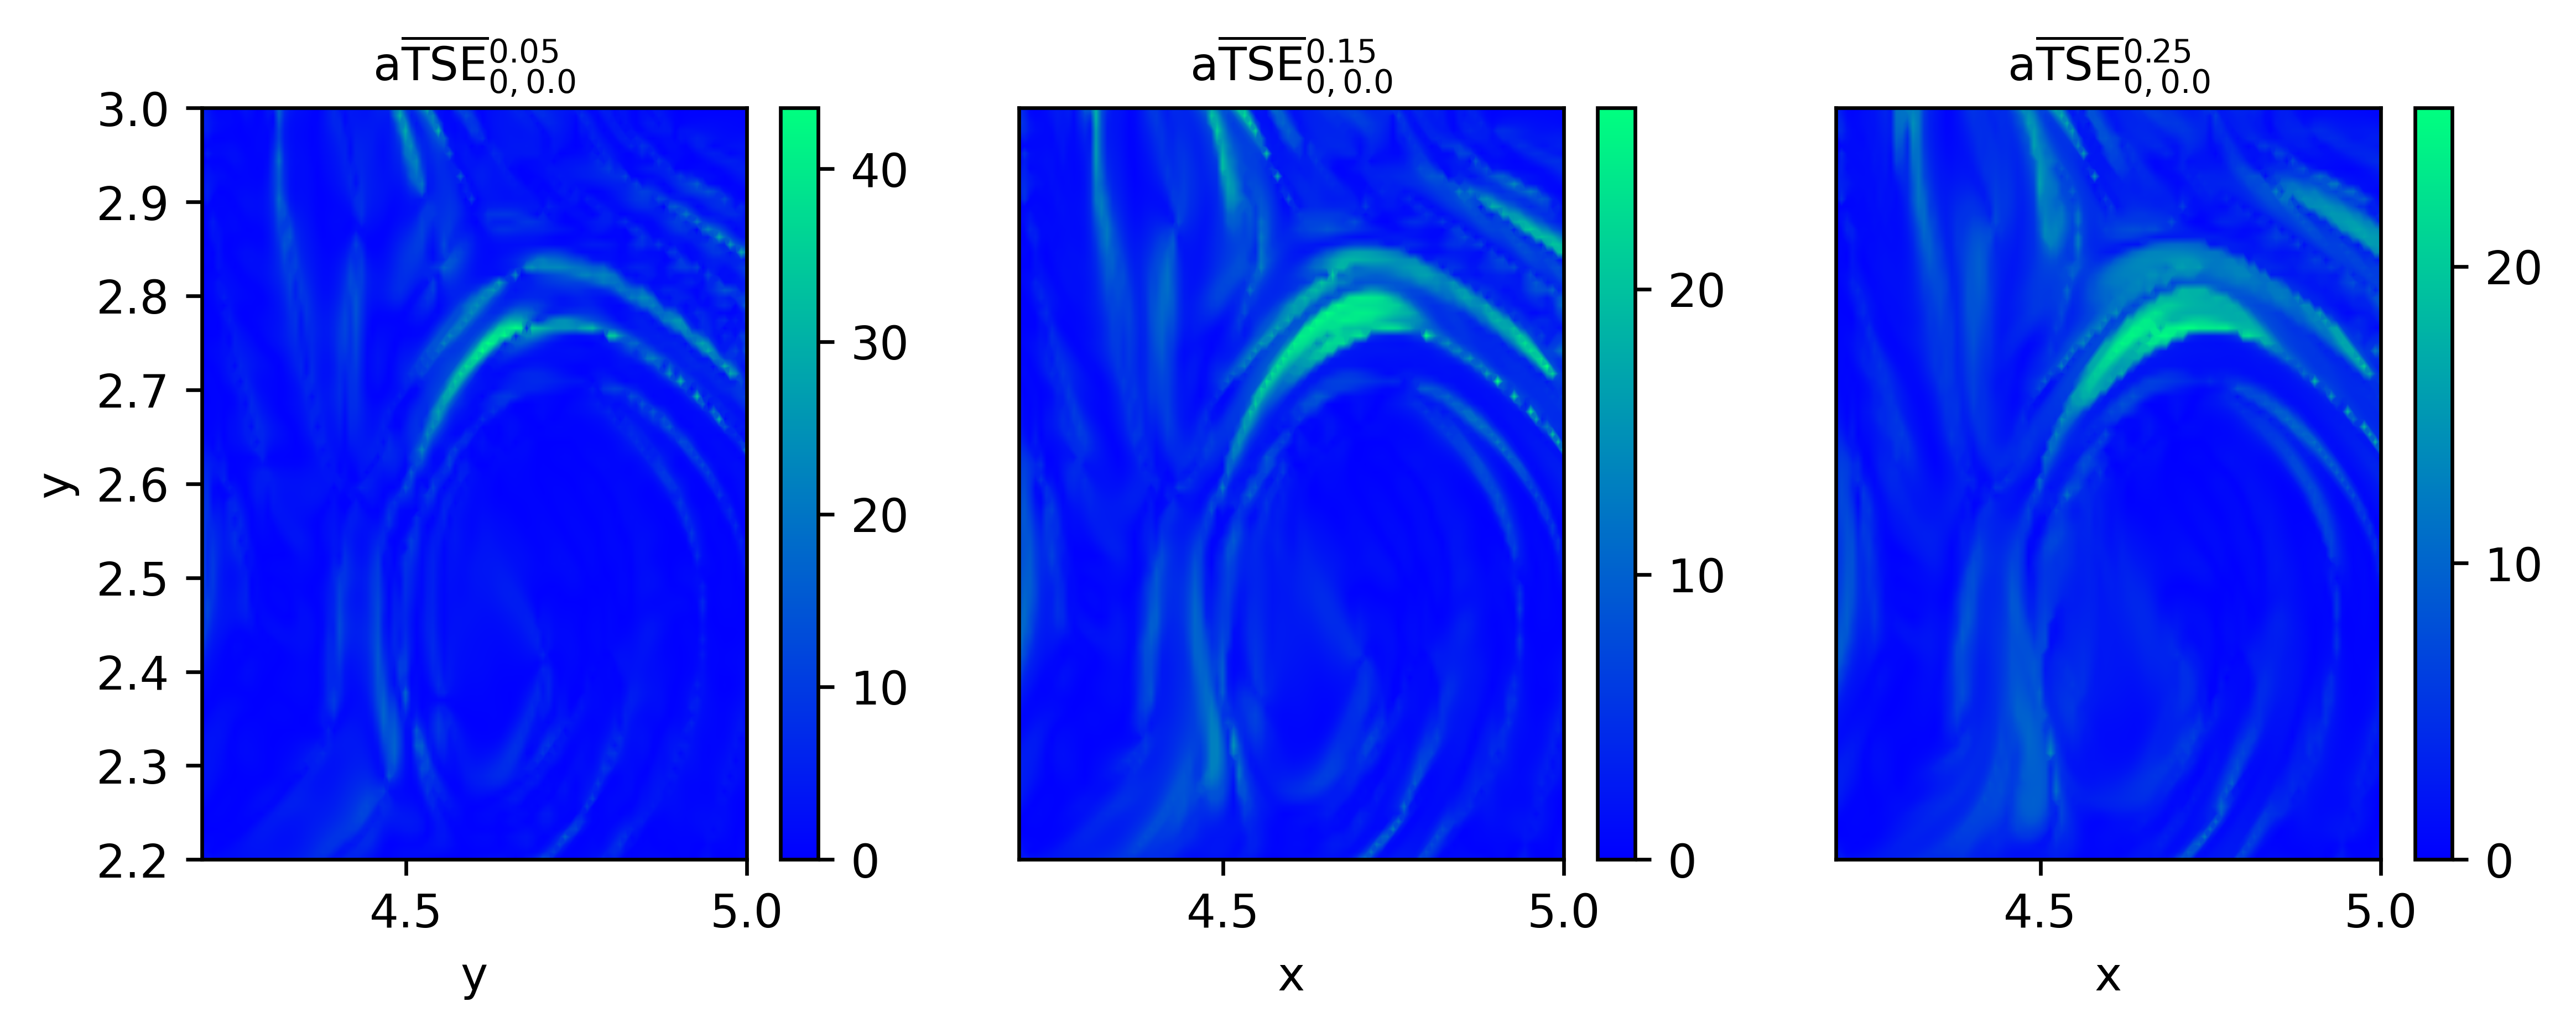

In [16]:
################################################ PLOT RESULTS ################################################

# Import plotting library
import matplotlib.pyplot as plt

# Figure/Axis
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, dpi = 600, figsize=(9, 3))

# Contourplot of aTSE_0^0.05 over meshgrid of initial conditions
cax = ax0.contourf(X_domain, Y_domain, aTSE[:,:,0], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax0, ticks = np.linspace(0, 40, 5))

# Contourplot of aTSE_0^0.15 over meshgrid of initial conditions
cax = ax1.contourf(X_domain, Y_domain, aTSE[:,:,1], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax1, ticks = np.linspace(0, 40, 5))

# Contourplot of aTSE_0^0.25 over meshgrid of initial conditions
cax = ax2.contourf(X_domain, Y_domain, aTSE[:,:,2], cmap = "winter", levels = 600)
# Colorbar
cbar = fig.colorbar(cax, ax = ax2, ticks = np.linspace(0, 40, 5))

# Axis ticks
ax1.set_yticks([])
ax2.set_yticks([])

# Axis Labels
ax0.set_ylabel("y", fontsize = 10)
ax0.set_xlabel("y", fontsize = 10)
ax1.set_xlabel("x", fontsize = 10)
ax2.set_xlabel("x", fontsize = 10)

ax0.set_title(r'$ \mathrm{a\overline{TSE}}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[50], 2)}}}$', fontsize = 10)
ax1.set_title(r'$ \mathrm{a\overline{TSE}}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[150], 2)}}}$', fontsize = 10)
ax2.set_title(r'$ \mathrm{a\overline{TSE}}$'+f'$_{{0,{np.around(s_dummy[0], 2)}}}^{{{np.around(s_dummy[-1], 2)}}}$', fontsize = 10)

plt.show()